In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import datetime

NameError: name 'plotnine' is not defined

In [64]:
df = pd.read_csv("complete_train.csv")
df = df.reset_index(drop=True)
df['date_time'] = pd.to_datetime(df['date_time'])
bad_sess = df[(df['id'] == 134) & (df['observation'] == 1) & (df['date_time'] >= "2019-10-09 13:05:05") & (df['date_time'] <= "2019-10-09 14:30:05")]
df.head()

,0_x,0_y,0_z,1_x,1_y,1_z,2_x,2_y,2_z,3_x,...,798_y,798_z,799_x,799_y,799_z,posture,id,observation,step,date_time
0,-0.922,-0.336,0.012,-0.961,-0.363,0.008,-0.977,-0.371,0.004,-0.980,...,-0.438,-0.160,-0.852,-0.438,-0.164,sitting,124.0,2.0,0.0,2019-08-29 09:31:00
1,-0.855,-0.422,-0.168,-0.867,-0.414,-0.172,-0.879,-0.418,-0.176,-0.895,...,-0.434,-0.207,-0.855,-0.438,-0.207,sitting,124.0,2.0,0.0,2019-08-29 09:31:10
2,-0.852,-0.430,-0.219,-0.855,-0.434,-0.211,-0.852,-0.434,-0.219,-0.852,...,-0.461,-0.211,-0.844,-0.461,-0.207,sitting,124.0,2.0,0.0,2019-08-29 09:31:20
3,-0.836,-0.449,-0.219,-0.844,-0.457,-0.211,-0.848,-0.461,-0.211,-0.844,...,-0.520,-0.152,-0.785,-0.527,-0.156,sitting,124.0,2.0,0.0,2019-08-29 09:31:30
4,-0.777,-0.523,-0.164,-0.773,-0.531,-0.164,-0.773,-0.531,-0.164,-0.777,...,-0.422,-0.195,-0.875,-0.418,-0.188,sitting,124.0,2.0,0.0,2019-08-29 09:31:40


In [ ]:
point_event = pd.read_csv("step_ground_truth.csv")
point_event["date_time"] = pd.to_datetime(point_event["Date"] + " " + point_event["Time"].str.split('0 days ').str[-1], format="mixed")

In [182]:
def get_basics(row_num):
    cols = df.columns[:2400]
    df_sub = df.iloc[[row_num]]
    id = df_sub["id"].iloc[0].astype(int)
    session = df_sub["observation"].iloc[0].astype(int)
    date_time = df_sub["date_time"].iloc[0]
    posture = df_sub["posture"].iloc[0]
    temp = pd.melt(df_sub, value_vars=cols)
    temp["measurement"] = temp["variable"].map(lambda x: int(x.split('_')[0]))
    temp["axis"] = temp["variable"].map(lambda x: x.split('_')[1])
    temp.drop(columns = "variable", axis=1, inplace=True)
    temp = temp.pivot(index = ["measurement"], columns="axis", values = "value").reset_index()
    temp["date_time"] = pd.date_range(date_time, periods=len(temp), freq='12.5ms')
    temp["date_time"] = pd.to_datetime(temp["date_time"], format="%Y-%m-%d %H:%M:%S.%f")
    return temp, id, session, posture

def graph_xyz(row_num):
    temp, id, session,posture = get_basics(row_num)
    temp['xyz'] = np.linalg.norm(temp[['x', 'y', 'z']], axis=1) - 1
    sub = f"ID = {id}, Session = {session}"
    p = (ggplot(temp, aes(x='measurement', y='xyz')) +
     scale_y_continuous(limits = [-1.5,1.5]) +
     geom_line() +
     labs(x='Measurement', y='Acceleration', title='Normalized Accelerometer Data for 10 Second Epoch', subtitle = sub) +
     theme_minimal()
     )
    return p

In [208]:
def graph_acceleration_and_steps(row_num):
    acc, id, session, posture = get_basics(row_num)
    minTime = acc["date_time"].min()
    maxTime = acc["date_time"].max()
    point_acc = point_event[(point_event["ID"] == id) & (point_event["Session"] == session) & (point_event["date_time"] >= minTime) & (point_event["date_time"] <= maxTime)]
    close_list = get_closest_ms(point_acc)
    point_acc1 = point_acc.copy()
    point_acc1["rel_ms"] = close_list
    point_acc2 = point_acc1.copy()
    point_acc2["join_time"] = pd.to_datetime(point_acc2['date_time'].dt.strftime('%Y-%m-%d %H:%M:%S')) + pd.to_timedelta(point_acc2["rel_ms"]*1000, unit="ms")
    acc['xyz'] = np.linalg.norm(acc[['x', 'y', 'z']], axis=1) - 1
    joined = pd.merge(acc, point_acc2[["date_time", "Step", "join_time"]], left_on="date_time", right_on="join_time", how="outer")
    
    sub = f"ID = {id}, Session = {session}, Posture = {posture}"
    p = (ggplot(joined, aes(y='xyz')) +
         scale_y_continuous(limits = [-1.5,1.5]) +
         geom_line(aes(x="date_time_x")) +
         geom_point(aes(x='date_time_y'), color="red" ) +
         labs(x='Measurement', y='Acceleration', title='Normalized Accelerometer Data for 10 Second Epoch', subtitle=sub) +
        scale_x_datetime(date_breaks="1 second",
                   date_labels = "%H:%M:%S") +
         theme(figure_size=(8,5))
         )
    return p
    
def get_closest_ms(point_acc):
    #Closest ms
    true_ms = []
    for i, row in point_acc.iterrows():
        true_ms.append(row["date_time"].microsecond/1000000)
    point_acc["true_ms"] = true_ms
        
    pos_ms_80Hz = [i/80 for i in range(0,80)]
    checks = [i/160 for i in range(0, 160)]
    
    cur_ms = 0
    close_list = []
    for i, row in point_acc.iterrows():
        true = row["true_ms"]
        closest_ms = 0
        for j in range(len(checks)):
            if true >= checks[j]:
                if j == len(checks)-1: #reached end, closest to 0
                    closest_ms = 0
                elif true <= checks[j+1]:
                    if checks[j] in pos_ms_80Hz:
                        closest_ms = checks[j]
                    else: 
                        closest_ms = checks[j+1]
        close_list.append(closest_ms)
    return close_list

In [210]:
graph_acceleration_and_steps(1000)
graph_acceleration_and_steps(1000).save(filename = 'walk1.png', height=5, width=8, units = 'in', dpi=1000)
graph_acceleration_and_steps(1094)
graph_acceleration_and_steps(1094).save(filename = 'walkWLoad1.png', height=5, width=8, units = 'in', dpi=1000)

C:\Users\jadyn\AppData\Local\Temp\ipykernel_4000\2020927587.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jadyn\AppData\Local\Temp\ipykernel_4000\2020927587.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jadyn\College\4_FourthYear\spring_2024\data_452\PointEventPlots\.venv\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 8 x 5 in image.
C:\Users\jadyn\College\4_FourthYear\spring_2024\data_452\PointEventPlots\.venv\lib\site-packages\plotnine\ggplot.py:607: Plotnine

# Walk with load plot

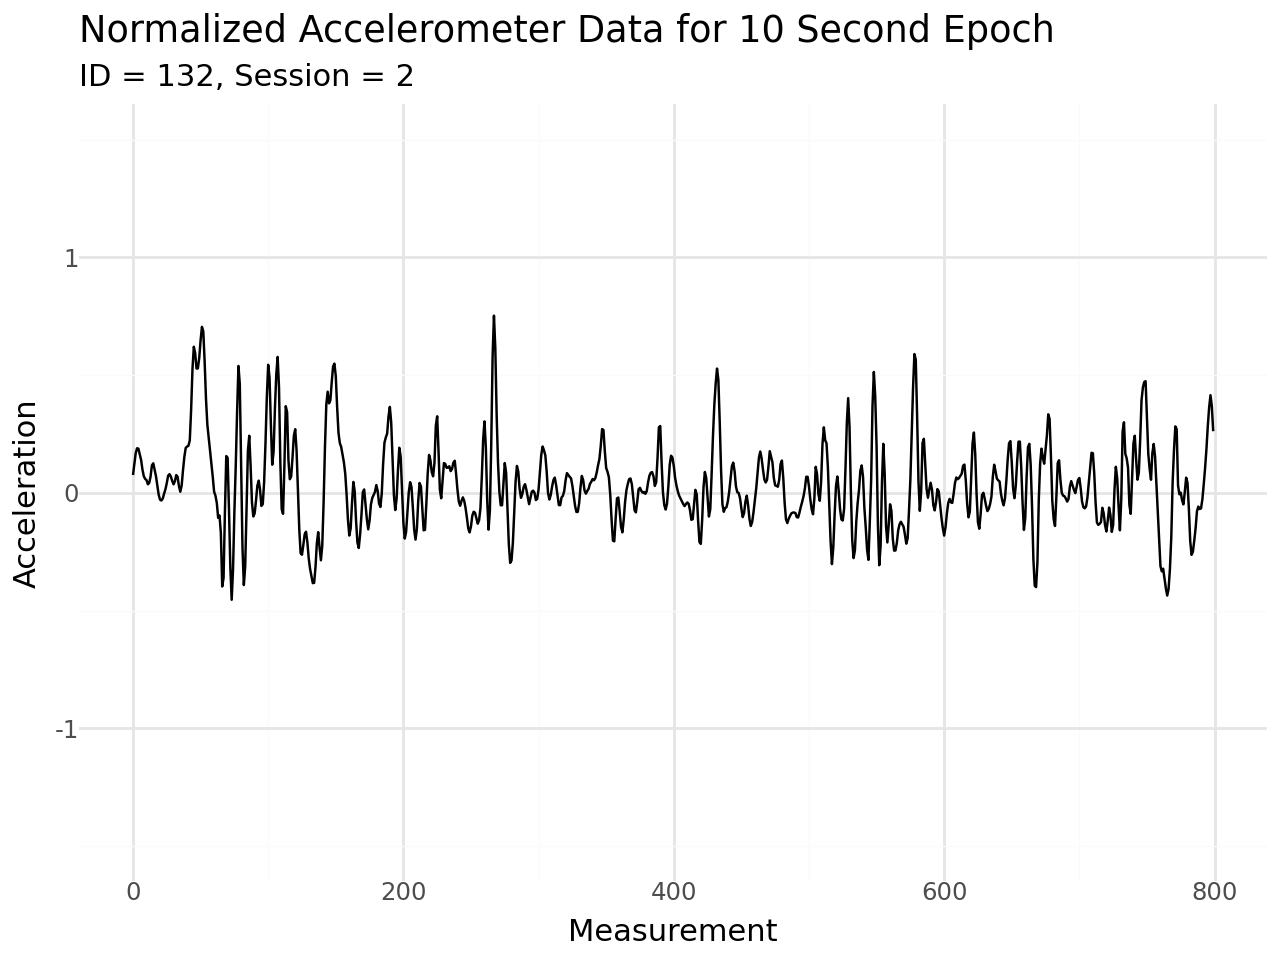

In [29]:
graph_xyz(1094)